In [1]:
%pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

2024-01-23 17:23:31.473254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load labels file
df = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/Fog_Project_Code/datasets/fog_aware_stats_new_labels.csv')
df = df[['photo', 'Label_new','Label_train']]
# Set image directory
img_dir = '/home/smmrrr/Fog_Imaging_Project/sta_221/all_surfline_photos/'

In [4]:
label_counts = df['Label_new'].value_counts()

print("Label Counts:")
print(label_counts)

Label Counts:
not_foggy    6981
foggy        1015
Name: Label_new, dtype: int64


In [6]:
1015/6981

0.14539464260134652

In [5]:
label_counts

not_foggy    6981
foggy        1015
Name: Label_new, dtype: int64

In [13]:
display(df)

,photo,Label_new,Label_train
0,2022_07-04.0000_agatebeachor.jpg,not_foggy,0
1,2022_07-04.0000_otterrockor.jpg,not_foggy,0
2,2022_07-04.0700_agatebeachor.jpg,not_foggy,0
3,2022_07-04.0730_agatebeachor.jpg,not_foggy,0
4,2022_07-04.0730_otterrockor.jpg,not_foggy,0
...,...,...,...
7991,2023_09-30.1900_agatebeachor.jpg,not_foggy,0
7992,2023_09-30.1930_cannonbeach.jpg,not_foggy,0
7993,2023_09-30.2000_otterrockor.jpg,not_foggy,0
7994,2023_09-30.2030_otterrockor.jpg,not_foggy,0


In [7]:
label_counts.loc['not_foggy'] - label_counts.loc['foggy']

5966

In [8]:

# Number of data points to drop from the "non-foggy" class
num_to_drop = label_counts.loc['not_foggy'] - label_counts.loc['foggy']

# Check if the number to drop is greater than the count of "non-foggy" class
if num_to_drop > label_counts[0]:
    print("Warning: The specified number of data points to drop is greater than the count of 'foggy' class.")
else:
    # Randomly drop data points from the "non-foggy" class
    df_to_drop = df[df['Label_train'] == 0].sample(n=num_to_drop, random_state=42)
    df_filtered = df.drop(df_to_drop.index)

    # Display the resulting DataFrame
    print(df_filtered)
    print(label_counts)


                                  photo  Label_new  Label_train
4       2022_07-04.0730_otterrockor.jpg  not_foggy            0
9       2022_07-04.0830_otterrockor.jpg  not_foggy            0
16    2022_07-04.0930_lincolncityor.jpg  not_foggy            0
34      2022_07-04.1300_otterrockor.jpg  not_foggy            0
55      2022_07-04.1700_otterrockor.jpg  not_foggy            0
...                                 ...        ...          ...
7969    2023_09-29.2100_cannonbeach.jpg  not_foggy            0
7972  2023_09-30.1030_pacificcityor.jpg  not_foggy            0
7980  2023_09-30.1300_lincolncityor.jpg  not_foggy            0
7982    2023_09-30.1330_cannonbeach.jpg  not_foggy            0
7986   2023_09-30.1600_agatebeachor.jpg  not_foggy            0

[2030 rows x 3 columns]
not_foggy    6981
foggy        1015
Name: Label_new, dtype: int64


In [9]:
label_counts = df_filtered['Label_train'].value_counts()

print("Label Counts:")
print(label_counts)

Label Counts:
0    1015
1    1015
Name: Label_train, dtype: int64


In [10]:
# Load images and labels
data = []
labels = []

for index, row in df_filtered.iterrows():
    img_path = os.path.join(img_dir, row['photo'])
    try:
        img = load_img(img_path, target_size=(100, 100))  # Specify the target size of your images
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
    img_array = img_to_array(img)

    # Edge detection using Canny algorithm
    gray_image = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)

    # Stack the original image and edges as input
    img_with_edges = np.dstack([img_array, edges])
    
    data.append(img_with_edges)
    labels.append(row['Label_train'])

In [11]:
# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Ensure labels are in the format 0 or 1 for binary classification
labels = labels.astype(int)

In [12]:
# Normalize pixel values to be between 0 and 1
data = data / 255.0

In [13]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [14]:
len(X_train)
len(X_test)

406

In [15]:
# Build CNN Model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 4)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model with specified learning rate
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        1184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

2024-01-23 17:24:20.257675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
%pip install pydot


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


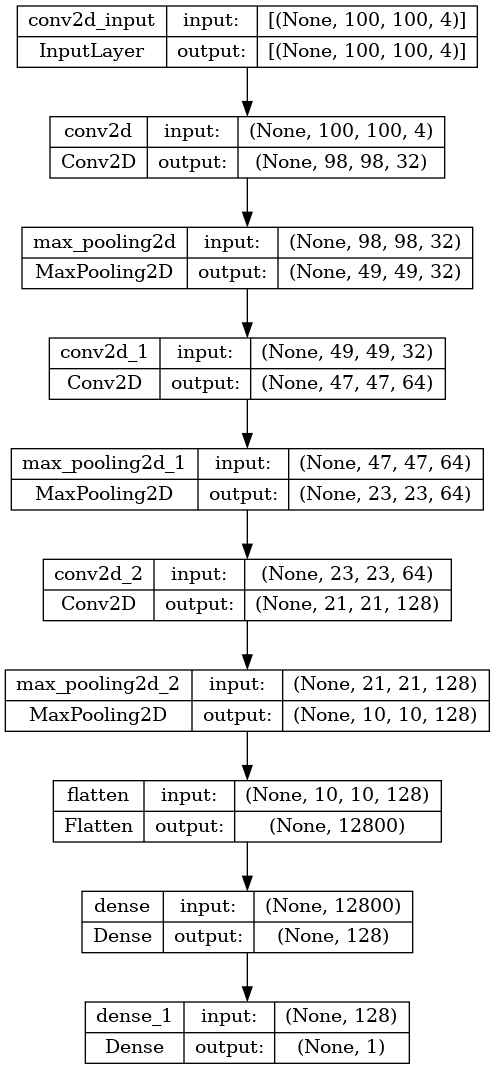

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [18]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/10
51/51 [==============================] - 6s 104ms/step - loss: 1.4735 - accuracy: 0.6305 - val_loss: 0.2531 - val_accuracy: 0.8793
Epoch 2/10
51/51 [==============================] - 5s 95ms/step - loss: 0.2562 - accuracy: 0.8873 - val_loss: 0.2105 - val_accuracy: 0.8966
Epoch 3/10
51/51 [==============================] - 5s 95ms/step - loss: 0.2565 - accuracy: 0.8990 - val_loss: 0.1908 - val_accuracy: 0.9212
Epoch 4/10
51/51 [==============================] - 5s 94ms/step - loss: 0.2135 - accuracy: 0.9064 - val_loss: 0.2832 - val_accuracy: 0.9113
Epoch 5/10
51/51 [==============================] - 5s 98ms/step - loss: 0.1970 - accuracy: 0.9175 - val_loss: 0.2305 - val_accuracy: 0.9089
Epoch 6/10
51/51 [==============================] - 5s 93ms/step - loss: 0.1712 - accuracy: 0.9243 - val_loss: 0.1749 - val_accuracy: 0.9163
Epoch 7/10
51/51 [==============================] - 5s 96ms/step - loss: 0.1763 - accuracy: 0.9255 - val_loss: 0.1901 - val_accuracy: 0.9163
Epoch 8/10
5

In [21]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/10
216/216 [==============================] - 75s 337ms/step - loss: 0.6505 - accuracy: 0.8567 - val_loss: 0.2680 - val_accuracy: 0.8986
Epoch 2/10
216/216 [==============================] - 71s 327ms/step - loss: 0.2476 - accuracy: 0.9060 - val_loss: 0.2318 - val_accuracy: 0.9108
Epoch 3/10
216/216 [==============================] - 71s 327ms/step - loss: 0.2373 - accuracy: 0.9105 - val_loss: 0.2302 - val_accuracy: 0.9096
Epoch 4/10
216/216 [==============================] - 71s 328ms/step - loss: 0.2327 - accuracy: 0.9140 - val_loss: 0.2378 - val_accuracy: 0.9050
Epoch 5/10
216/216 [==============================] - 70s 323ms/step - loss: 0.2149 - accuracy: 0.9166 - val_loss: 0.2168 - val_accuracy: 0.9108
Epoch 6/10
216/216 [==============================] - 69s 321ms/step - loss: 0.2004 - accuracy: 0.9213 - val_loss: 0.2128 - val_accuracy: 0.9102
Epoch 7/10
216/216 [==============================] - 70s 325ms/step - loss: 0.1920 - accuracy: 0.9219 - val_loss: 0.2474 - val_ac

In [19]:
# Display additional metrics
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

13/13 [==============================] - 0s 26ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       210
           1       0.88      0.96      0.92       196

    accuracy                           0.92       406
   macro avg       0.92      0.92      0.92       406
weighted avg       0.92      0.92      0.92       406



In [21]:
import pickle
path_names = '/home/smmrrr/Fog_Imaging_Project/Fog_Project_Code/datasets/edge_detection_unlabeled_photos_name_index.pkl'
path = '/home/smmrrr/Fog_Imaging_Project/Fog_Project_Code/datasets/edge_detection_unlabeled_photos.pkl'

with open(path_names, 'rb') as f:
    names_all_photos = pickle.load(f)
with open(path, 'rb') as f:
    all_photos = pickle.load(f)


In [22]:
all_photos = np.array(all_photos)
all_photos.shape

(22831, 100, 100, 4)

In [30]:
all_photos = all_photos / 255.0

In [23]:
X_train.shape

(1624, 100, 100, 4)

In [28]:
X_train

array([[[[0.43529412, 0.44313726, 0.4392157 , 0.        ],
         [0.45882353, 0.46666667, 0.4627451 , 1.        ],
         [0.48235294, 0.49019608, 0.4862745 , 0.        ],
         ...,
         [0.4862745 , 0.5058824 , 0.52156866, 0.        ],
         [0.47058824, 0.49019608, 0.5058824 , 0.        ],
         [0.4509804 , 0.47058824, 0.4862745 , 0.        ]],

        [[0.42745098, 0.43529412, 0.43137255, 0.        ],
         [0.45882353, 0.46666667, 0.4627451 , 1.        ],
         [0.48235294, 0.49019608, 0.4862745 , 0.        ],
         ...,
         [0.49019608, 0.50980395, 0.5254902 , 0.        ],
         [0.47058824, 0.49019608, 0.5058824 , 0.        ],
         [0.45490196, 0.4745098 , 0.49019608, 0.        ]],

        [[0.4392157 , 0.44705883, 0.44313726, 0.        ],
         [0.45882353, 0.46666667, 0.4627451 , 1.        ],
         [0.4862745 , 0.49411765, 0.49019608, 0.        ],
         ...,
         [0.49019608, 0.50980395, 0.5254902 , 0.        ],
         [

In [31]:
#####does the model make sense when run on all photos?

results = model.predict(all_photos)

714/714 [==============================] - 12s 17ms/step


In [32]:
results.mean()

0.2426616

In [27]:
filename = 'edge_detection.sav'
pickle.dump(model, open(filename, 'wb'))
model.save('cnn_edgedetection.keras')  # The file needs to end with the .keras extension


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Si

In [15]:
def plot_confusion_matrix(y_test, y_test_pred, model_name):
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    group_names = ['True Negative (TN)', 'False Positive (FP)',
                'False Negative (FN)', 'True Positive (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in test_confusion_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Creating the heatmap
    plt.figure(figsize=(10,7))
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title("Confusion Matrix for "+ model_name+ " (using Test Set)")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

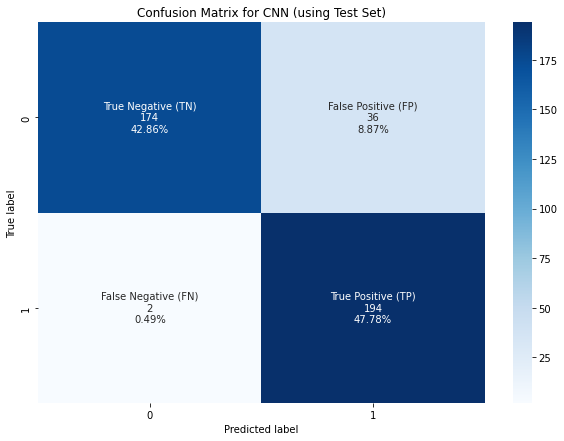

In [16]:
# Confusion Matrix
import seaborn as sns

plot_confusion_matrix(y_test, y_pred_binary, "CNN")


In [39]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

In [40]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

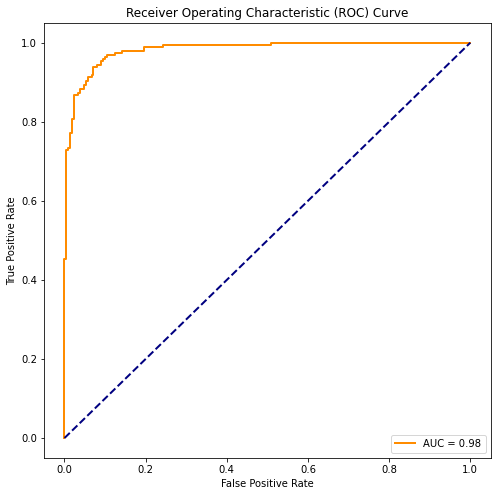

In [41]:
# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

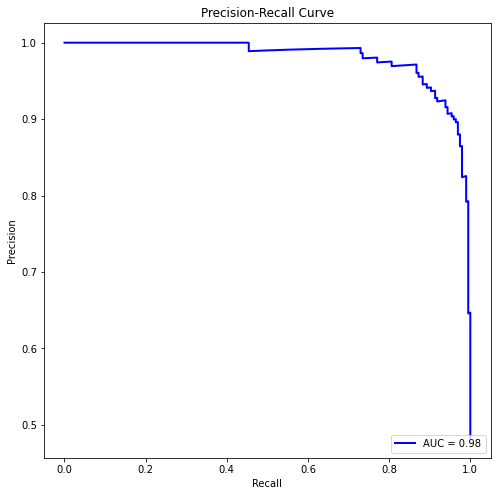

In [42]:
# Plot Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [43]:
links_and_labels_loop = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/Fog_Project_Code/unlabeled_photos_for_model.csv')
image_dir = '/home/smmrrr/surfline/'

# Load images and labels
data = []
labels = []

for index, row in links_and_labels_loop.iterrows():
    img_path = os.path.join(image_dir, row['photo'])
    img = load_img(img_path, target_size=(100, 100))  # Specify the target size of your images
    img_array = img_to_array(img)

    # Edge detection using Canny algorithm
    gray_image = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)

    # Stack the original image and edges as input
    img_with_edges = np.dstack([img_array, edges])
    
    data.append(img_with_edges)
    labels.append(row['photo'])

KeyboardInterrupt: 